- Автор: Морозова Влада Викторовна

# Исследовательский анализ данных в Python и проверка гипотез

Исследовательский анализ данных в Python для выявления инсайтов об изменении пользовательских предпочтений и популярности событий осенью 2024 года в сервисе-агрегаторе продажи билетов на мероприятия, а также проверка гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

## Описание данных

Всего три таблицы:

- `final_tickets_orders_df.csv` — таблица с информацией обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных на период с 1 июня по 30 октября 2024 года.

---
- `final_tickets_events_df.csv` — таблица с информацией о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

---
- `final_tickets_tenge_df.csv` — таблица с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.


## Цель 
Выявить изменения пользовательских предпочтений и найти события популярные осенью 2024 года в сервисе по продаже билетов, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.


## 📋 Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Предобработка данных, предварительное исследование
3. Исследовательский анализ данных
4. Статистический анализ данных
5. Выводы и рекомендации

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

In [2]:
orders_df = pd.read_csv('final_tickets_orders_df.csv', parse_dates=['created_dt_msk', 'created_ts_msk'])

display(orders_df.info(), orders_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

None

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


Датафрейм `orders_df` содержит 14 столбцов и 290849 строк, в которых представлена информация о всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Типы данных и наименования столбцов корректны, пропуски есть в колонке `days_since_prev`, которая содержит количество дней с предыдущей покупки для каждого пользователя, если покупки не было, то данные содержат пропуск.

---

In [3]:
events_df = pd.read_csv('final_tickets_events_df.csv')

display(events_df.info(), events_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


Датафрейм `events_df` содержит 11 столбцов и 22427 строк, в которых представлена информация о событиях, включая город и регион события, а также площадку проведения мероприятия. Типы данных и наименования столбцов корректны, пропуски отсутствуют.

---

In [4]:
tenge_df = pd.read_csv('final_tickets_tenge_df.csv', parse_dates = ['data'])

display(tenge_df.info(), tenge_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


None

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Датафрейм `tenge_df` содержит 4 столбца и 357 строк, в которых представлена информация о курсе тенге к российскому рублю за 2024 год. Типы данных и наименования столбцов корректны, пропуски отсутствуют.

---

## Предобработка данных, предварительное исследование
---

In [5]:
for column in ['order_id', 'event_id', 'age_limit', 'tickets_count']:
    orders_df[column] = pd.to_numeric(orders_df[column], downcast = 'integer')
                                         
for column in ['revenue', 'total', 'days_since_prev']:
    orders_df[column] = pd.to_numeric(orders_df[column], downcast = 'float')   
    
for column in ['event_id', 'city_id', 'venue_id']:
    events_df[column] = pd.to_numeric(events_df[column], downcast = 'integer')

In [6]:
for column in ['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
    print(f'\nУникальные значения в столбце {column}: {orders_df[column].sort_values().unique()}')

unique_etm = events_df['event_type_main'].unique()
print(f'\nУникальные значения в столбце event_type_main: {unique_etm}')   

for column in ['event_type_description', 'organizers', 'region_name', 'city_name', 'venue_name', 'venue_address']:
    print(f'\nКоличество уникальных значений в столбце {column}: {events_df[column].sort_values().nunique()}')
    print(f'\nУникальные значения в столбце {column}:')
    print(events_df[column].sort_values().unique())


Уникальные значения в столбце cinema_circuit: ['Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм' 'нет']

Уникальные значения в столбце age_limit: [ 0  6 12 16 18]

Уникальные значения в столбце currency_code: ['kzt' 'rub']

Уникальные значения в столбце device_type_canonical: ['desktop' 'mobile']

Уникальные значения в столбце service_name: ['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']

Уникальные значения в столбце event_type_main: ['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']

Количество уникаль

- События типа `фильмы` были исключены из анализа, так как их количество незначительно. Однако в данных сохранились мероприятия, проводимые в сетях кинотеатров.


- Количество адресов площадок превышает число самих площадок. Это указывает на то, что некоторые локации включают несколько точек для проведения мероприятий.


- В данных представлено более 4000 организаторов, что демонстрирует высокую диверсификацию рынка.


- Мероприятия разделены на 5 возрастных групп — от 0+ до 18+.


- В столбце `event_type_description` некоторые типы мероприятий некорректно прописаны, например: 
    - `музыкальный спектакль` и `спектакль` могут пересекаться по смыслу; 
    - `шоу` и `цирковое шоу` тоже близки; 
    - неясно, что подразумевается под типом `подарок` и `событие`;
    - `спорт` и `спортивное мероприятие` это тоже самое;
    - `снегурочка` и `ёлка` можно объединить и назвать `новогодние мероприятия`


- Общие параметры данных: 
    1. Валюта: рубли и тенге.
    2. География: 81 регион и 352 города.
    3. Устройства: только мобильные и десктопные заказы (выборка корректна).
    
---

In [7]:
for df_name, df in [('orders_df', orders_df), ('events_df', events_df), 
                    ('tenge_df', tenge_df)]:
    print(f'\nПолные дубликаты в датафрейме {df_name}: {df.duplicated().sum()}')


Полные дубликаты в датафрейме orders_df: 0

Полные дубликаты в датафрейме events_df: 0

Полные дубликаты в датафрейме tenge_df: 0


In [8]:
columns_to_check = [col for col in orders_df.columns if col != 'order_id']

duplicates = orders_df[orders_df.duplicated(subset=columns_to_check)]

duplicates = duplicates.sort_values(by=columns_to_check)

display(duplicates.head(10))
print(f'Всего дубликатов в датафрейме orders_df: {len(duplicates)}')

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.820000,Билеты в руки,1,997.479980,0.0
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.230000,Лови билет!,2,280.809998,0.0
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.189999,Билеты в руки,3,739.849976,0.0
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.959999,Лучшие билеты,4,674.119995,0.0
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.839996,Билеты без проблем,1,3170.949951,0.0
154178,5373179,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.839996,Билеты без проблем,1,3170.949951,0.0
154993,3463819,7eb4fc207ecc10f,2024-09-21,2024-09-21 11:43:58,448579,нет,0,rub,mobile,2.540000,Лови билет!,1,84.820000,0.0
156215,6657995,7eb4fc207ecc10f,2024-10-26,2024-10-26 09:39:03,418836,нет,0,rub,mobile,294.850006,Лови билет!,3,4914.209961,0.0
174584,6114564,8d6c1ff89fac35f,2024-10-31,2024-10-31 22:28:57,589624,нет,16,rub,desktop,41.830002,Мой билет,1,1045.750000,0.0
176439,8248210,8f95286aa5fd8d7,2024-06-20,2024-06-20 10:57:19,244875,нет,0,rub,mobile,15.730000,Лови билет!,3,524.390015,0.0


Всего дубликатов в датафрейме orders_df: 30


30 дубликатов – это менее 0.1% от 290K заказов (низкий риск искажения данных), лучше мы избавимся от них. 

In [9]:
orders_df = orders_df.drop_duplicates(subset=columns_to_check)

In [10]:
merged_df = pd.merge(orders_df, events_df, on = 'event_id', how = 'left')

pd.set_option('display.max_columns', 100)
display(merged_df.head())

print("\nДоля пропусков в таблице merged_df:")
display(merged_df.isna().mean())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,Край билетов,4,10870.990234,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,Мой билет,2,2067.510010,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,За билетом!,4,13984.160156,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,Лови билет!,2,212.279999,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,Билеты без проблем,3,10695.429688,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"



Доля пропусков в таблице merged_df:


order_id                  0.000000
user_id                   0.000000
created_dt_msk            0.000000
created_ts_msk            0.000000
event_id                  0.000000
cinema_circuit            0.000000
age_limit                 0.000000
currency_code             0.000000
device_type_canonical     0.000000
revenue                   0.000000
service_name              0.000000
tickets_count             0.000000
total                     0.000000
days_since_prev           0.075442
event_name                0.000818
event_type_description    0.000818
event_type_main           0.000818
organizers                0.000818
region_name               0.000818
city_name                 0.000818
city_id                   0.000818
venue_id                  0.000818
venue_name                0.000818
venue_address             0.000818
dtype: float64

In [11]:
revenue_rubs = merged_df[merged_df['currency_code']=='rub']['revenue'].copy()
revenue_kzt = merged_df[merged_df['currency_code']=='kzt']['revenue'].copy()

In [12]:
rub_stats = revenue_rubs.describe()
kzt_stats = revenue_kzt.describe()

pd.concat((rub_stats, kzt_stats), axis=1).set_axis(['rub', 'kzt'], axis=1)

,rub,kzt
count,285750.000000,5069.000000
mean,547.588257,4995.162598
std,871.519165,4916.759766
min,-90.760002,0.000000
25%,113.862501,518.099976
50%,346.179993,3698.830078
75%,791.700012,7397.660156
max,81174.539062,26425.859375


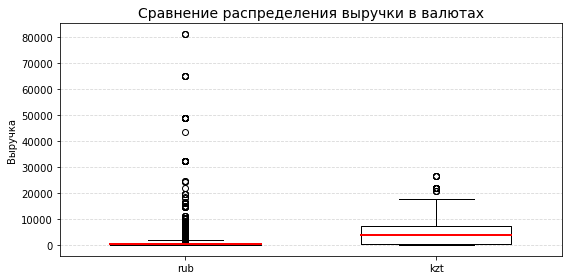

In [13]:
data = [revenue_rubs, revenue_kzt]
labels = ['rub', 'kzt']

plt.figure(figsize=(8, 4))

box = plt.boxplot(
    data,
    labels=labels,
    widths=0.6,                                   
    medianprops={'color': 'red', 'linewidth': 2}
)

plt.title('Сравнение распределения выручки в валютах', fontsize=14)
plt.ylabel('Выручка', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Подавляющее большинство транзакций (98.3%) совершено в рублях.

- Средний чек в тенге кажется выше, но это связано с разницей в курсе (1 руб ≈ 5 тенге). После конвертации средний чек в `kzt` окажется сопоставимым или ниже.

- В обеих валютах есть значительный разброс, это указывает на разнообразие мероприятий (от дешевых до премиальных).
- Возвраты - заказы в рублях с отрицательной суммой.

- При сравнении среднего и медианы заказы в тенге имеют более равномерное распределение, чем заказы в рублях.

- Максимум в тенге после конвертации (~ 4-5к руб.) значительно меньше максимума в рублях. Выбросы в рублях могут быть крупными заказами: групповые билеты или VIP-мероприятия. 

В следующем шаге мы проведем конвертацию для единообразного анализа.

---

In [14]:
kzt_orders = merged_df[merged_df['currency_code'] == 'kzt'].merge(
    tenge_df,
    left_on='created_dt_msk',
    right_on='data',
    how='left'
)

kzt_orders['revenue_rub'] = kzt_orders['revenue'] / kzt_orders['nominal'] * kzt_orders['curs']

In [15]:
merged_df['revenue_rub'] = merged_df['revenue']

merged_df.loc[merged_df['currency_code']== 'kzt', 'revenue_rub'] = kzt_orders['revenue_rub'].values

print(f"Количество конвертированных записей: {len(kzt_orders)}")

Количество конвертированных записей: 5069


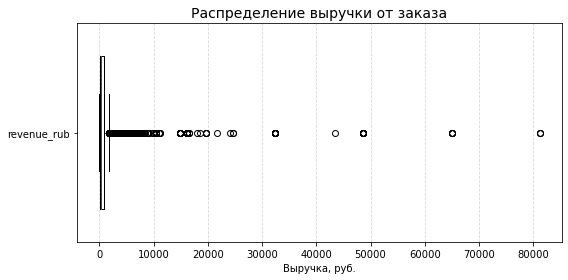

In [16]:
plt.figure(figsize=(8, 4))

box = plt.boxplot(
    merged_df['revenue_rub'],
    labels=['revenue_rub'],
    vert=False,
    widths=0.7,
    medianprops={'color': 'red', 'linewidth': 1}  
)

plt.title('Распределение выручки от заказа', fontsize=14)
plt.xlabel('Выручка, руб.', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [17]:
merged_df = merged_df[merged_df['revenue_rub'] > 0]

outliers = merged_df['revenue_rub'].quantile(0.99)
merged_df = merged_df.loc[merged_df['revenue_rub'] < outliers]

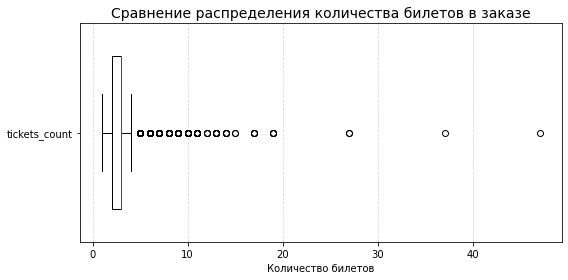


Статистика по tickets_count:


count    281695.000000
mean          2.743982
std           1.157546
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

In [18]:
plt.figure(figsize=(8, 4))

box = plt.boxplot(
    merged_df['tickets_count'],
    labels=['tickets_count'],
    vert=False,
    widths=0.7,
    medianprops={'color': 'red', 'linewidth': 1}
)

plt.title('Сравнение распределения количества билетов в заказе', fontsize=14)
plt.xlabel('Количество билетов', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
print("\nСтатистика по tickets_count:")
display(merged_df['tickets_count'].describe())

In [19]:
outliers_tickets = merged_df['tickets_count'].quantile(0.99)
merged_df = merged_df.loc[merged_df['tickets_count'] < outliers_tickets]

- Среднее и медиана `tickets_count` близки (2.74 и 3 соответственно), что указывает на равномерное распределение. 
- Большинство пользователей покупают 1–3 билета (вероятно, индивидуальные или групповые посещения). 
- Отклонение от среднего невелико (±1 билет), что говорит о стабильности. 

Как и в случае с выручкой от продажи билетов, ограничим данные количества проданных билетов 99-ым процентилем. 

---

In [20]:
merged_df['one_ticket_revenue_rub'] = merged_df['revenue_rub'] / merged_df['tickets_count']

In [21]:
merged_df['month'] = merged_df['created_dt_msk'].dt.month

merged_df['season'] = np.where(merged_df['month'] < 9, 'лето', 'осень')

In [22]:
pd.set_option('display.max_columns', 100)
display(merged_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,Край билетов,4,10870.990234,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,Мой билет,2,2067.510010,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,За билетом!,4,13984.160156,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,Лови билет!,2,212.279999,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,Билеты без проблем,3,10695.429688,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410034,463.470001,10,осень


Объединённая таблица содержит `283336 строк и 28 столбцов`, включая полную информацию о заказах билетов, соответствующих мероприятиях, городах, регионах и площадках проведения. Данные получены в результате слияния таблиц `events_df и orders_df`.
В 10 столбцах менее 0.001% пропусков, в колонке `days_since_prev` менее 0.1%. 

Предобработка данных:
- Проведена проверка на дубликаты и пропуски.
- Для единообразия анализа проведена конвертация выручки из тенге в рубли.
- Оптимизированы типы данных:
    1. Дата и время приведены к корректному формату.
    2. Числовые колонки сжаты для экономии памяти.


- Устранены аномалии:
    1. Отфильтрованы значения по 99-му процентилю для количества билетов (`tickets_count`) и выручки (`revenue_rub`).
    2. Исключены строки с отрицательной выручкой (возвраты).


- Добавленные колонки:
    1. `revenue_rub` — выручка с заказа в рублях.
    2. `one_ticket_revenue_rub` — средняя выручка с одного билета.
    3. `month` — месяц оформления заказа.
    4. `season` — сезонность (лето/осень).
    
---

## Исследовательский анализ данных

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

Для каждого месяца найдем количество заказов и визуализируем результаты.

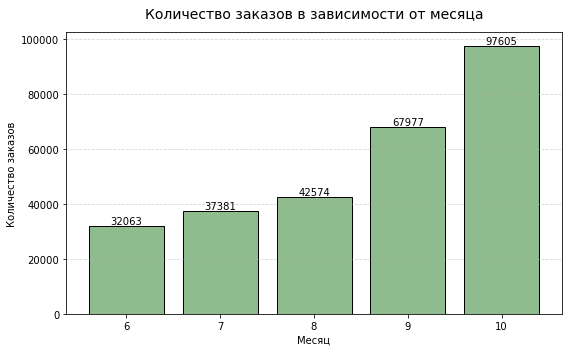

In [23]:
monthly_orders = (merged_df.groupby('month')['order_id']
                  .nunique()
                  .reset_index(name='total_orders') 
                  .sort_values('month'))

plt.figure(figsize=(8, 5))

bars = plt.bar(monthly_orders['month'], monthly_orders['total_orders'], color='#8FBC8F', edgecolor='k')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             str(bar.get_height()), 
             ha='center', va='bottom')

plt.title('Количество заказов в зависимости от месяца', pad=15, fontsize=14)
plt.xlabel('Месяц', fontsize=10)
plt.ylabel('Количество заказов', fontsize=10)
plt.grid(True, axis='y',linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Фиксируем **увеличение** заказов от июня к ноябрю 2024 года. Особенно виден рост показателя в осенний период. 

---

Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: 
- тип мероприятия, 
- тип устройства, 
- категория мероприятия по возрастному рейтингу. 

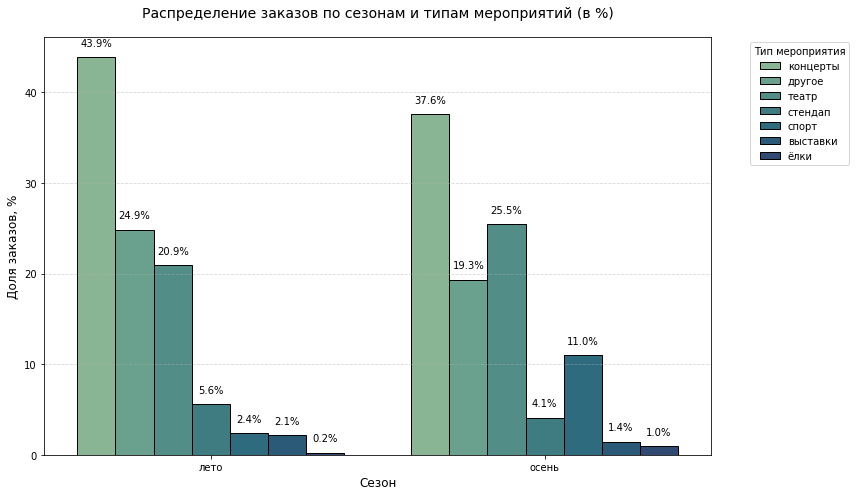

In [24]:
season_analysis = merged_df.copy()

season_orders = season_analysis.groupby('season')['order_id'].nunique().reset_index(name='total_season_orders')

seasonal_orders_by_type = (season_analysis.groupby(['season', 'event_type_main'])['order_id']
                          .nunique()
                          .reset_index(name='type_orders')
                          .sort_values(['season', 'type_orders'], ascending=[True, False]))

seasonal_orders_by_type = seasonal_orders_by_type.merge(season_orders, on='season')
seasonal_orders_by_type['perc'] = seasonal_orders_by_type['type_orders'] / seasonal_orders_by_type['total_season_orders'] * 100

plt.figure(figsize=(12, 7))

ax = sns.barplot(data=seasonal_orders_by_type, 
            x='season', 
            y='perc', 
            hue='event_type_main',
            palette='crest',
            edgecolor='k')

plt.title('Распределение заказов по сезонам и типам мероприятий (в %)', pad=20, fontsize=14)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Доля заказов, %', fontsize=12)
plt.legend(title='Тип мероприятия', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha="center", va="bottom")

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Безусловными лидерами в летний период являются концерты (43.9%) и "другое" (24.9%). Высокий спрос может быть связан с:
    1. Проведением мероприятий на открытом воздухе,
    2. Летними фестивалями и массовыми гуляниями,
    3. Сезоном отпусков и туристической активностью.


- Ёлки демонстрируют минимальную активность (0.2%), что логично для летнего сезона.
- Стендап и выставки пользуются примерно равным интересом ±1-1.5%.
- Топ-3 наиболее популярных категорий в оба сезона: концерты, другое, театр.

- Театральные постановки и спортивные мероприятия показывают сниженные показатели, вероятно из-за:
    1. Летних каникул в театрах,
    2. Подготовительного периода у спортсменов и организаций.


- В осенний период популярность концертов упала на 6.3%, однако заметен значительный рост спроса на:
    1. Театральные мероприятия (увеличение на 4.5% по сравнению с летом),
    2. Спортивные события (рост на 8.6%),
    3. Сохраняется высокий интерес к концертам и категории "другое". 
 
---

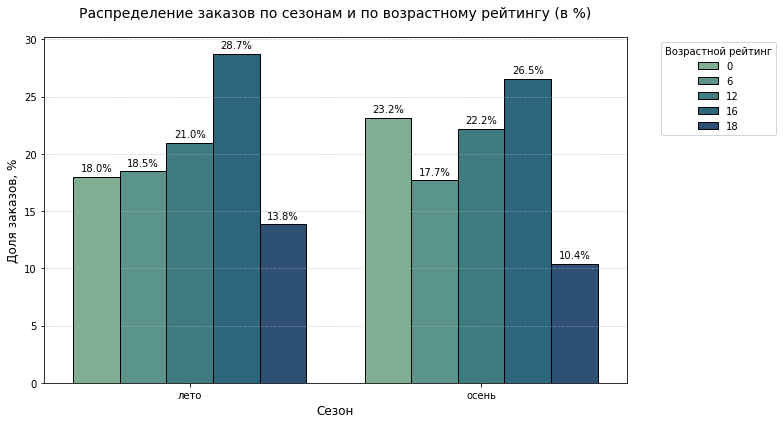

In [25]:
seasonal_orders_by_age = (season_analysis.groupby(['season', 'age_limit'])['order_id']
                          .nunique()
                          .reset_index(name='age_orders')
                          .sort_values(['season', 'age_orders'], ascending=[True, False]))

seasonal_orders_by_age = seasonal_orders_by_age.merge(season_orders, on='season')
seasonal_orders_by_age['perc'] = seasonal_orders_by_age['age_orders'] / seasonal_orders_by_age['total_season_orders'] * 100


plt.figure(figsize=(11, 6))
ax = sns.barplot(data=seasonal_orders_by_age, 
            x='season', 
            y='perc', 
            hue='age_limit',
            palette='crest',
            edgecolor='k')

plt.title('Распределение заказов по сезонам и по возрастному рейтингу (в %)', pad=20, fontsize=14)
plt.ylabel('Доля заказов, %', fontsize=12)
plt.xlabel('Сезон', fontsize=12)
plt.legend(title='Возрастной рейтинг', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.3,
            f'{height:.1f}%',
            ha="center", va="bottom")

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- В летний период преобладают мероприятия для взрослой аудитории (16+ и 18+) с долей 28.7% и 13.8% соответственно.

- Детские мероприятия (0+, 6+, 12+) демонстрируют более низкий спрос по сравнению с осенью (хотя суммарно более 50%).

- Наименьший интерес к мероприятиям с рейтингом 18+.

- В осенний период заметен значительный рост спроса на детские мероприятия:

     - 0+: рост с 18.0% до 23.2%
     -12+: увеличение с 21.0% до 22.2%


- Снижение популярности мероприятий для взрослых:

     - 16+: уменьшение с 28.7% до 26.5%
     - 18+: падение с 13.8% до 10.4%


- Летом соотношение взрослых/детских мероприятий ≈ **42%/58%**. Осенью соотношение детских мероприятий растет ≈ **37%/63%**. 

---

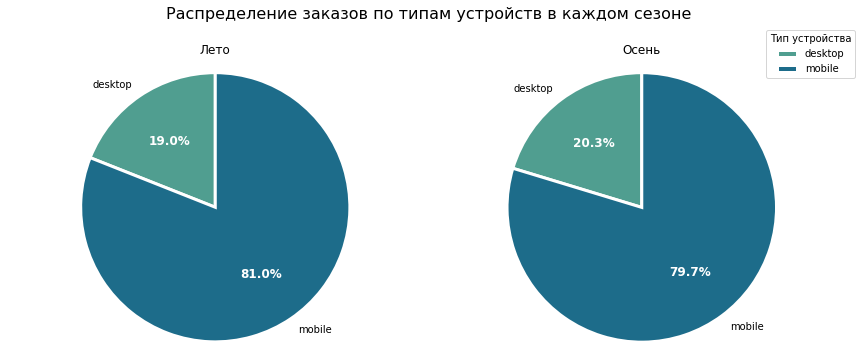

In [26]:
orders_by_devices = season_analysis.groupby(['season', 'device_type_canonical'])['order_id'].nunique().unstack()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Распределение заказов по типам устройств в каждом сезоне', fontsize=16, y=1.0)

colors = sns.color_palette('crest', orders_by_devices.shape[1])

wedges1, texts1, autotexts1 = ax1.pie(orders_by_devices.loc['лето'], 
                                      labels=orders_by_devices.columns, 
                                      autopct='%1.1f%%', 
                                      startangle=90, 
                                      colors=colors, 
                                      wedgeprops={'edgecolor': 'white', 'linewidth': 3})
ax1.set_title('Лето', fontsize=12)
ax1.axis('equal')

wedges2, texts2, autotexts2 = ax2.pie(orders_by_devices.loc['осень'],
                                      labels=orders_by_devices.columns,
                                      autopct='%1.1f%%', startangle=90,
                                      colors=colors,
                                      wedgeprops={'edgecolor': 'white', 'linewidth': 3})
ax2.set_title('Осень', fontsize=12)
ax2.axis('equal')
fig.legend(orders_by_devices.columns, title='Тип устройства', bbox_to_anchor=(1.0, 0.95))

for autotext in autotexts1 + autotexts2:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color('white') 

plt.tight_layout()
plt.show()

- Доминирование мобильных устройств сохраняется в оба сезона (около 80% заказов), так как это удобно и быстро. 

- Минимальная сезонная разница (±1%) свидетельствует о стабильности пользовательских привычек и незначительном влиянии сезона на выбор устройства.

- Возможные причины увеличения на 1% декстопных заказов осенью это покупки с ПК в рабочее время. 

---

Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

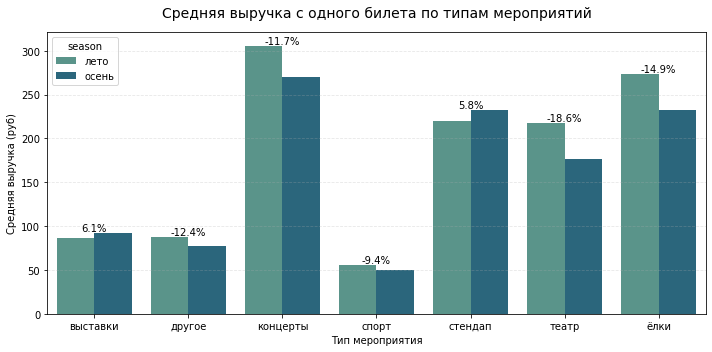


Таблица с результатами:


season,event_type_main,лето,осень,change_pct
0,выставки,86.7,92.0,6.1%
1,другое,87.8,76.9,-12.4%
2,концерты,305.5,269.7,-11.7%
3,спорт,55.5,50.3,-9.4%
4,стендап,219.4,232.2,5.8%
5,театр,217.3,176.9,-18.6%
6,ёлки,273.8,233.0,-14.9%


In [27]:
rev_by_type = (season_analysis.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
                      .mean()
                      .unstack(level='season')
                      .reset_index())

rev_by_type['change_pct'] = round(100 * (rev_by_type['осень'] - rev_by_type['лето']) / rev_by_type['лето'], 2)

plt.figure(figsize=(10, 5))
sns.barplot(data=rev_by_type.melt(id_vars=['event_type_main'], 
                              value_vars=['лето', 'осень'], 
                              var_name='season',
                              value_name='avg_revenue'),
            x='event_type_main',
            y='avg_revenue',
            hue='season',
            palette='crest')

plt.title('Средняя выручка с одного билета по типам мероприятий', fontsize=14, pad=15)
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя выручка (руб)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
 
for i, row in rev_by_type.iterrows():
    plt.text(i, max(row['лето'], row['осень']), 
             f"{row['change_pct']:.1f}%", 
             ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

result_table = rev_by_type[['event_type_main', 'лето', 'осень', 'change_pct']]

styled_table = (result_table.style
                .format({'лето': '{:.1f}', 'осень': '{:.1f}', 'change_pct': '{:.1f}%'})
                .background_gradient(cmap='Blues', subset=['change_pct']))
print("\nТаблица с результатами:")
display(styled_table)

**Топ по средней выручке**: концерты, ёлки, стендап. 

Рост выручки осенью:
- Выставки: +6.1% 
- Стендап: +5.8% 


Снижение выручки:
- Театр: -18.6% 
- Ёлки: -14.9% 
- Другое: -12.4%
- Концерты: -11.7%
- Спорт: -9.4%


Несмотря на общее снижение выручки в осенний период, выставки и стендап-шоу демонстрируют рост средней стоимости билетов.

Значительное падение выручки у остальных мероприятий требует особого внимания. Возможно, появились льготные билеты на некоторые мероприятия.

Аномально высокая летняя выручка на новогодние ёлки, вероятно, могла быть корпоративным заказом или ранним бронированием.

---

### 3.2. Осенняя активность пользователей

Изучим активность пользователей осенью 2024 года.

Проанализируем динамику изменений по дням для: 
- общего числа заказов; 
- количества активных пользователей DAU; 
- среднего числа заказов на одного пользователя; 
- средней стоимости одного билета.

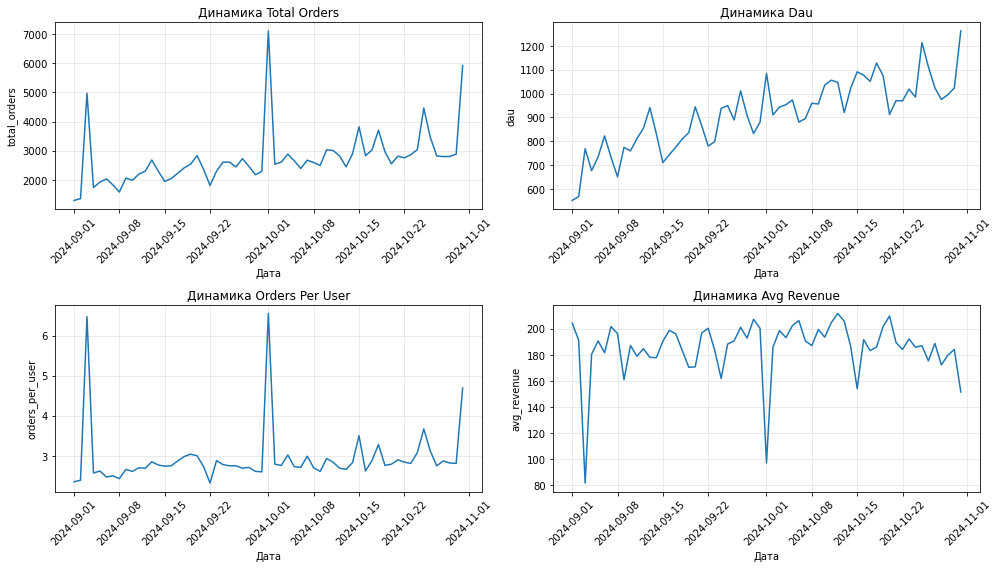


Метрики по дням:


,total_orders,dau,avg_revenue,orders_per_user
created_dt_msk,,,,
2024-09-01,1293,551,204.283569,2.35
2024-09-02,1357,567,191.260208,2.39
2024-09-03,4971,768,81.595901,6.47
2024-09-04,1736,676,180.398834,2.57
2024-09-05,1921,733,190.613907,2.62


In [28]:
df_autumn = merged_df[merged_df['month'].isin([9, 10])].copy()

daily_metrics = df_autumn.groupby('created_dt_msk').agg({
    'order_id': 'count',              
    'user_id': 'nunique',              
    'one_ticket_revenue_rub': 'mean'  
}).rename(columns={
    'order_id': 'total_orders',
    'user_id': 'dau',
    'one_ticket_revenue_rub': 'avg_revenue'
})

daily_metrics['orders_per_user'] = round(daily_metrics['total_orders'] / daily_metrics['dau'], 2)

plt.figure(figsize=(14, 8))
for i, col in enumerate(['total_orders', 'dau', 'orders_per_user', 'avg_revenue'], 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=daily_metrics, x=daily_metrics.index, y=col)
    plt.title(f'Динамика {col.replace("_", " ").title()}')
    plt.xlabel('Дата')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nМетрики по дням:")
display(daily_metrics.head())

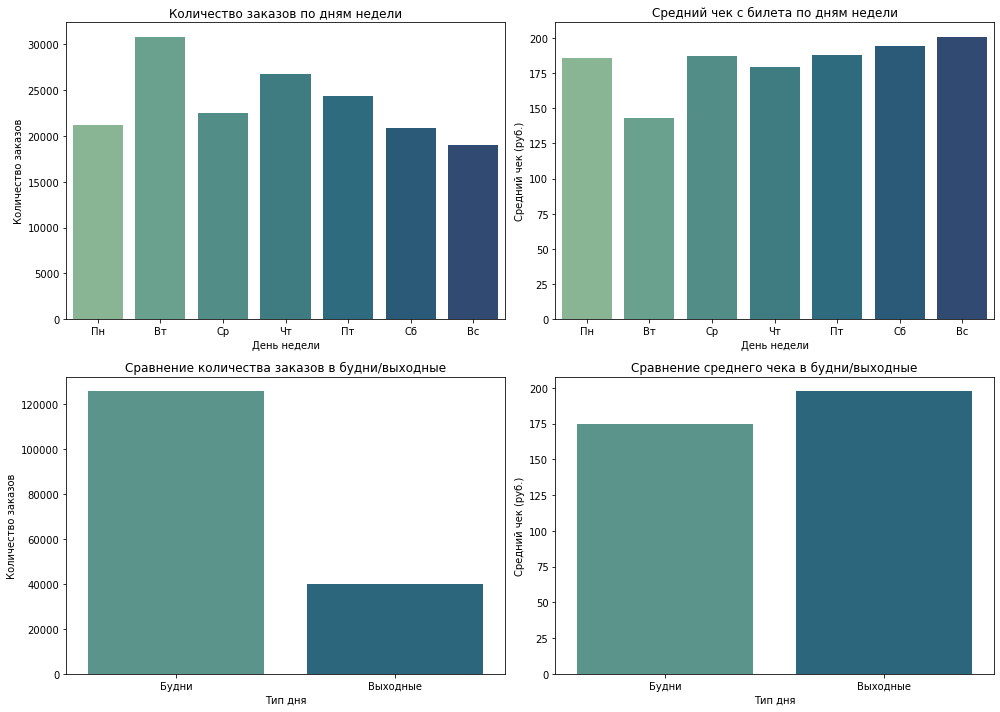


Метрики по дням недели:


,weekday_name,total_orders,dau,avg_revenue,orders_per_user
weekday,,,,,
0,Пн,21219,4412,185.675842,4.81
1,Вт,30853,4752,142.779846,6.49
2,Ср,22541,4773,187.531387,4.72
3,Чт,26810,4933,179.238663,5.43
4,Пт,24316,4805,187.971344,5.06
5,Сб,20851,4489,194.470673,4.64
6,Вс,18992,4306,201.015381,4.41



Сравнение будни/выходные:


,total_orders,dau,avg_revenue,orders_per_user
is_weekend,,,,
False,125739,13112,174.554337,9.59
True,39843,7025,197.590347,5.67


In [29]:
df_week_activity = df_autumn.copy()

df_week_activity['weekday'] = df_week_activity['created_dt_msk'].dt.weekday 
df_week_activity['is_weekend'] = df_week_activity['weekday'].isin([5, 6])  

weekday_metrics = df_week_activity.groupby('weekday').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'
}).rename(columns={
    'order_id': 'total_orders',
    'user_id': 'dau',
    'one_ticket_revenue_rub': 'avg_revenue'
})

weekday_metrics['orders_per_user'] = round(weekday_metrics['total_orders'] / weekday_metrics['dau'], 2)

weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
weekday_metrics['weekday_name'] = weekday_names

weekend_contrast = df_week_activity.groupby('is_weekend').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'
}).rename(columns={
    'order_id': 'total_orders',
    'user_id': 'dau',
    'one_ticket_revenue_rub': 'avg_revenue'
})

weekend_contrast['orders_per_user'] = round(weekend_contrast['total_orders'] / weekend_contrast['dau'], 2)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=weekday_metrics, x='weekday_name', y='total_orders', order=weekday_names, palette='crest')
plt.title('Количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')

plt.subplot(2, 2, 2)
sns.barplot(data=weekday_metrics, x='weekday_name', y='avg_revenue', order=weekday_names, palette='crest')
plt.title('Средний чек с билета по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средний чек (руб.)')

plt.subplot(2, 2, 3)
sns.barplot(data=weekend_contrast.reset_index(), x='is_weekend', y='total_orders', palette='crest')
plt.title('Сравнение количества заказов в будни/выходные')
plt.xlabel('Тип дня')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.ylabel('Количество заказов')

plt.subplot(2, 2, 4)
sns.barplot(data=weekend_contrast.reset_index(), x='is_weekend', y='avg_revenue', palette='crest')
plt.title('Сравнение среднего чека в будни/выходные')
plt.xlabel('Тип дня')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.ylabel('Средний чек (руб.)')

plt.tight_layout()
plt.show()

print("\nМетрики по дням недели:")
display(weekday_metrics[['weekday_name', 'total_orders', 'dau', 'avg_revenue', 'orders_per_user']])

print("\nСравнение будни/выходные:")
display(weekend_contrast)

На графиках динамики изменений количества заказов и пользователей по дням наблюдается восходящий тренд — с течением времени эти показатели стабильно растут.

Максимальное количество заказов приходится на вторник и четверг (в абсолютном и в соотношении к кол-ву пользователей). Пользователи заранее планируют мероприятия на конец рабочей недели и выходные, при этом размер среднего чека в эти дни падает. Можно заметить тенденцию - количество заказов коррелирует среднему чеку. 

Наименьшая активность наблюдается в понедельник и среду — типичное поведение для будних дней.

Несмотря на выходной (Вс), количество заказов ниже, чем в пятницу и субботу, это может быть связано с подготовкой к рабочей неделе и меньшим количеством мероприятий в этот день.

С суботы по понедельник клиентов около 4.4к, далее показатель растет и стремится к 5 тысячам пользователей.

Выходные (суббота и воскресенье) приносят на 70% меньше заказов, чем в будние дни.

Выходные дни лидируют по среднему чеку — выше на 12% по сравнению с буднями. Вероятно влияние покупок более дорогих билетов на популярные события.

---

### 3.3. Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам, это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. 

In [30]:
region_analysis = df_autumn.copy()

region_metrics = region_analysis.groupby(['region_name']).agg({
    'order_id': 'count',              
    'event_id': 'nunique',              
    'revenue_rub': 'sum'       
}).rename(columns={
    'order_id': 'total_orders',
    'event_id': 'total_events',
    'revenue_rub': 'sum_revenue'
}).reset_index()

region_metrics['perc_orders'] = round(100 * region_metrics['total_orders'] / region_analysis['order_id'].count(), 1)
region_metrics['perc_events'] = round(100 * region_metrics['total_events'] / region_analysis['event_id'].nunique(), 1)
region_metrics['perc_revenue'] = round(100 * region_metrics['sum_revenue'] / region_analysis['revenue_rub'].sum(), 1)

region_metrics = region_metrics.sort_values(by=['perc_revenue'], ascending=False)

region_metrics.head()

,region_name,total_orders,total_events,sum_revenue,perc_orders,perc_events,perc_revenue
23,Каменевский регион,45874,3882,27940164.0,27.7,24.7,34.799999
59,Североярская область,20258,2580,10205643.0,12.2,16.4,12.700000
44,Озернинский край,7444,293,6628288.0,4.5,1.9,8.300000
75,Широковская область,8528,790,4137273.5,5.2,5.0,5.200000
40,Малиновоярский округ,4493,135,3626546.0,2.7,0.9,4.500000


**Топ-5 регионов** по доле заказов (от общего числа):
- Каменевский регион — 27,7%
- Североярская область — 12,2%
- Медовская область — 7,1%
- Широковская область — 5,2%
- Озернинский край — 4,5%

Далее доля снижается до 2,8% с постепенным уменьшением на 0,1% на каждый следующий регион.

В 60 регионах доля продаж составляет менее 1%. Из них у 30 регионов — менее 0,1%.

**Топ-5 регионов** (доля по мероприятиям):
- Каменевский регион — 24,7%
- Североярская область — 16,4%
- Широковская область — 5,0%
- Светополянский округ — 4,8%
- Речиновская область — 3,4%


**Топ-5 регионов** (доля по выручке):
- Каменевский регион — 34.8%
- Североярская область — 12.7%
- Озернинский край — 8.3%
- Широковская область — 5.2%
- Малиновоярский округ — 4.5%

**Итого:** 8 регионов обеспечивают больше половины заказов, мероприятий и выручки. 

Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. 

In [31]:
service_analysis = df_autumn.copy()

service_metrics = service_analysis.groupby(['service_name']).agg({
    'order_id': 'count',
    'event_id': 'nunique',
    'revenue_rub': 'sum'
}).rename(columns={
    'order_id': 'total_orders',
    'event_id': 'total_events',
    'revenue_rub': 'sum_revenue'
}).reset_index()

service_metrics['perc_orders'] = round(100 * service_metrics['total_orders'] / service_analysis['order_id'].count(), 2)
service_metrics['perc_events'] = round(100 * service_metrics['total_events'] / service_analysis['event_id'].nunique(), 2)
service_metrics['perc_revenue'] = round(100 * service_metrics['sum_revenue'] / service_analysis['revenue_rub'].sum(), 2)

service_metrics = service_metrics.sort_values(by = ['perc_revenue'], ascending=False)

pd.options.display.float_format = '{:.2f}'.format
display(service_metrics.head(5))

,service_name,total_orders,total_events,sum_revenue,perc_orders,perc_events,perc_revenue
3,Билеты без проблем,31605,2805,12164603.00,19.09,17.87,15.15
24,Мой билет,19174,998,10595006.00,11.58,6.36,13.19
25,Облачко,15342,1401,10427507.00,9.27,8.92,12.98
21,Лови билет!,25329,3569,10131662.00,15.30,22.73,12.62
8,Весь в билетах,9309,597,9168831.00,5.62,3.80,11.42


**Топ-5 билетных операторов** (доля заказов):
- Билеты без проблем — 19,2%
- Лови билет! — 15,3%
- Билеты в руки — 15,2%
- Мой билет — 11,5%
- Облачко — 9,2%

**Топ-5 билетных операторов** (доля по мероприятиям):
- Лови билет! — 22,7%
- Билеты без проблем — 17,9%
- Билеты в руки — 15,5%
- Облачко — 8,9%
- Лучшие билеты — 8,7% 

**Топ-5 билетных операторов** (доля выручки):
- Билеты без проблем — 15,1%
- Мой билет — 13,2%
- Облачко — 13,0%
- Лови билет! — 12,6%
- Весь в билетах — 11,4%

Из 35 операторов:
- Только 14 имеют долю заказов более 1% и суммарную выручку свыше 1 млн рублей.
- 11 операторов с долей продаж менее 0,1% требуют пересмотра условий сотрудничества.

**Итого:** 6 билетных операторов отвечают за 70% заказов, мероприятий и выручки. 

## Статистический анализ данных

Коллеги из продуктового отдела хотят отдельно проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств. 

Гипотеза №1: 
- $H_0: \mu_{\text{desktop}} \leq \mu_{\text{mobile}}$ <br> Среднее количество заказов на одного пользователя мобильного приложения не отличается от заказов пользователей стационарных устройств.
    
- $H_1: \mu_{\text{mobile}} > \mu_{\text{desktop}}$ <br> Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Гипотеза №2:
- $H_0: \mu_{\text{desktop}} \leq \mu_{\text{mobile}}$ <br> Среднее время между заказами пользователей мобильных приложений не отличается с пользователями стационарных устройств. 
    
- $H_1: \mu_{\text{mobile}} > \mu_{\text{desktop}}$ <br> Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Группа А - пользователи мобильных устройств, группа В - пользователи стационарных устройств.

---

In [32]:
df_test = df_autumn.copy()

mobile_users = df_test[df_test['device_type_canonical']=='mobile']['user_id'].unique()
desktop_users = df_test[df_test['device_type_canonical']=='desktop']['user_id'].unique()

intersection = list(set(mobile_users) & set(desktop_users))
print(f'Пользователи, которые встречаются одновременно в группах A и B: {len(intersection)}')

Пользователи, которые встречаются одновременно в группах A и B: 3205


In [33]:
total_users_A = len(mobile_users)
total_users_B = len(desktop_users)

print(f'Размер выборки А: {total_users_A} юзеров, размер выборки В: {total_users_B}') 
print()

perc_diff = round(100 * (total_users_A - total_users_B)/ total_users_A, 2)

print(f'Процентная разница между выборками А и В составляет: {perc_diff}%')

Размер выборки А: 14024 юзеров, размер выборки В: 4825

Процентная разница между выборками А и В составляет: 65.59%


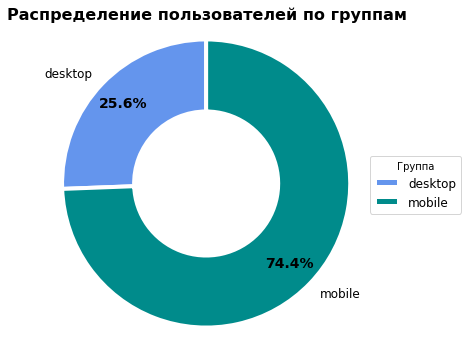

In [34]:
users_for_group = df_test.groupby('device_type_canonical')['user_id'].nunique()

plt.figure(figsize=(6, 5))

colors = ['cornflowerblue', 'darkcyan']

wedges, texts, autotexts = plt.pie(users_for_group,
                                   labels=users_for_group.index,            
                                   colors=colors, autopct='%1.1f%%',        
                                   startangle=90,                           
                                   wedgeprops={'width': 0.5,                
                                    'edgecolor': 'white', 'linewidth': 4},  
                                   textprops={'fontsize': 12},              
                                   pctdistance=0.80)                         

plt.title('Распределение пользователей по группам', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.axis('equal')
plt.legend(wedges, users_for_group.index, title="Группа", fontsize=12, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout() 

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.show()

Такая разница в количестве пользователей между группами является негативным фактором при проведении статистического анализа. Однако, будем следовать поставленной задаче и проведем анализ.

In [35]:
orders_A = df_test[df_test['device_type_canonical']=='mobile'].groupby('user_id')['order_id'].count().copy()
orders_B = df_test[df_test['device_type_canonical']=='desktop'].groupby('user_id')['order_id'].count().copy()

orders_A_stats = orders_A.describe()
orders_B_stats = orders_B.describe()

pd.concat((orders_A_stats, orders_B_stats), axis=1).set_axis(['mobile', 'desktop'], axis=1)

,mobile,desktop
count,14024.00,4825.00
mean,9.41,6.97
std,67.23,35.29
min,1.00,1.00
25%,1.00,1.00
50%,2.00,2.00
75%,5.00,4.00
max,4243.00,1453.00


Естественно, у заказов с мобильных устройств показатели выше, так как и выборка больше. 

Среднее и медиана у двух групп сильно отличаются, а на стандартное отклонение большое влияние оказывают выбросы (4243 и 1453 заказа). 

Далее займемся отчисткой данных от выбросов и проведем проверку на нормальность и гомогенность дисперсий.

In [36]:
q95_mobile = np.percentile(orders_A, 95)
q95_desktop = np.percentile(orders_B, 95)

mobile_filtered = orders_A[orders_A < q95_mobile]
desktop_filtered = orders_B[orders_B < q95_desktop]

_, p_mobile = shapiro(mobile_filtered.sample(1000))
_, p_desktop = shapiro(desktop_filtered.sample(1000))

_, p_levene = levene(mobile_filtered, desktop_filtered)

print(f"Нормальность (mobile): {p_mobile}, desktop: {p_desktop}")
print(f"Равенство дисперсий (Левен): {p_levene}")

Нормальность (mobile): 1.4277269533619831e-40, desktop: 3.6122671813365134e-41
Равенство дисперсий (Левен): 2.1299517527479176e-15


Распределения не нормальные (p << 0.05), дисперсии значительно различаются. К тому же значительно осложняет выбор теста тот факт, что выборки зависимы (в данных пользователи с двумя устройствами). 

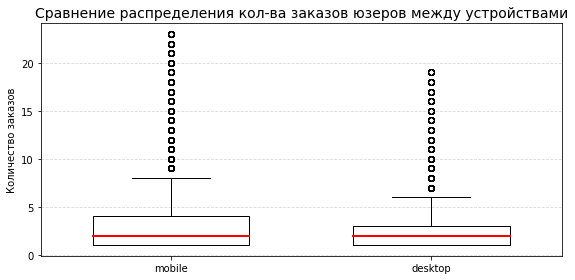

In [37]:
data = [mobile_filtered, desktop_filtered]
labels = ['mobile', 'desktop']

plt.figure(figsize=(8, 4))
box = plt.boxplot(
    data,
    labels=labels,
    widths=0.6,                                   
    medianprops={'color': 'red', 'linewidth': 2}   
)

plt.title('Сравнение распределения кол-ва заказов юзеров между устройствами', fontsize=14)
plt.ylabel('Количество заказов', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Теперь необходимо выбрать тест, перед этим подвести итог - какие данные мы получили:
1. Дисперсии групп значительно различаются;
2. Данные отклоняются от нормального распределения, одинаково скошены, длинный хвост справа;
3. Данные зависимы (есть пол-ли в двух группам);
4. Соотношение групп по количеству пол-лей примерно 1 к 4;
5. Количество наблюдений достаточно - в группе мобильных устройств - более 13к юзеров, у ПК более 4.5к.

In [38]:
orders_test = df_test.groupby(['device_type_canonical', 'user_id'])['order_id'].count().reset_index()
orders_test = orders_test.rename(columns={'order_id': 'total_orders'})

orders_test = orders_test[orders_test['total_orders'] < np.percentile(orders_test['total_orders'], 95)]

weights = np.where(
    orders_test['device_type_canonical'] == 'desktop', 
    4,  
    1   
)

# Взвешенный t-тест
cm = CompareMeans(
    DescrStatsW(orders_test[orders_test['device_type_canonical'] == 'mobile']['total_orders']),
    DescrStatsW(orders_test[orders_test['device_type_canonical'] == 'desktop']['total_orders'])
)

t_stat, p_value, _ = cm.ttest_ind(alternative='larger', usevar='unequal')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("\nОтвергаем H0: разница статистически значима")
else:
    print("\nНе отвергаем H0: недостаточно доказательств для принятия гипотезы Н1")

p-value: 1.2445358946163763e-09

Отвергаем H0: разница статистически значима


Мы смогли подтвердить, что среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

---

In [39]:
df_test_days = df_autumn.copy()

mobile_days = df_test_days[df_test_days['device_type_canonical']=='mobile']['days_since_prev']
desktop_days = df_test_days[df_test_days['device_type_canonical']=='desktop']['days_since_prev']
 
mobile_days = mobile_days[mobile_days > 0]
desktop_days = desktop_days[desktop_days > 0]

mobile_stats = mobile_days.describe()
desktop_stats = desktop_days.describe()

pd.concat((mobile_stats, desktop_stats), axis=1).set_axis(['mobile', 'desktop'], axis=1)

,mobile,desktop
count,38805.00,8143.00
mean,12.16,12.02
std,21.77,21.79
min,1.00,1.00
25%,1.00,1.00
50%,3.00,3.00
75%,11.00,11.00
max,148.00,146.00


Распределение времени между заказами пользователей в разрезе двух групп достаточно схожее. Медианы и квартили (25%, 75%) идентичны. Стандартные отклонения почти равны.

Среднее время между покупками выше у мобильных-пользователей, но незначительно (12.16 и 12.02 дней).

Стандартное отклонение 21.8 дней указывает на большой разброс в данных и сильную неоднородность поведения пользователей.

Выбросы встречаются в обеих группах, достигая максимума в 148 дней. Исключим их фильтрацией по 95-процентилю.

In [40]:
mobile_days = mobile_days[mobile_days < mobile_days.quantile(0.95)]
desktop_days = desktop_days[desktop_days < desktop_days.quantile(0.95)]

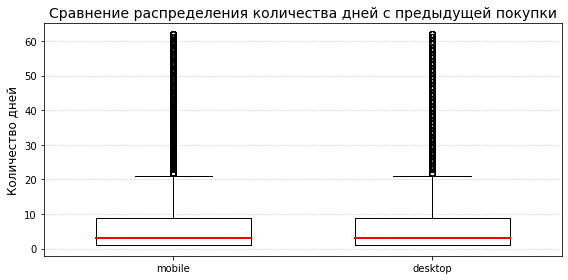

In [41]:
data = [mobile_days, desktop_days]
labels = ['mobile', 'desktop']

plt.figure(figsize=(8, 4))
box = plt.boxplot(
    data,
    labels=labels,
    widths=0.6,                                   
    medianprops={'color': 'red', 'linewidth': 2} 
)

plt.title('Сравнение распределения количества дней с предыдущей покупки', fontsize=14)
plt.ylabel('Количество дней', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [42]:
_, p_mobile = shapiro(mobile_days.sample(5000))
_, p_desktop = shapiro(desktop_days)

_, p_levene = levene(mobile_days, desktop_days)

print(f"Нормальность (mobile): {p_mobile}, desktop: {p_desktop}")
print(f"Равенство дисперсий (Левен): {p_levene:.2f}")

Нормальность (mobile): 0.0, desktop: 0.0
Равенство дисперсий (Левен): 0.24


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Данные достоверно отклоняются от нормального распределения, дисперсии групп равны.

Теперь необходимо выбрать тест, перед этим подвести итог - какие данные мы получили:
1. Дисперсии групп равны;
2. Данные отклоняются от нормального распределения, одинаково скошены, длинный хвост справа;
3. Данные зависимы (есть пол-ли в двух группам);
4. Соотношение групп по количеству пол-лей примерно 1 к 4;
5. Количество наблюдений достаточно - в группе мобильных устройств - почти 37к наблюдений, у ПК 7.7к.

Я решила получить ответ для "коллег из продуктового отдела" через статистический тест Манна-Уитни, раз он не такой чувствительный к выбросам и распределению.

In [43]:
stat, p_value = mannwhitneyu(mobile_days, 
                             desktop_days, 
                             alternative='greater')

print(f"Тест Манна-Уитни: p-value = {p_value:.2f}")
if p_value < 0.05:
    print("\nОтвергаем H0: разница статистически значима (PC > mobile)")
else:
    print("\nНе отвергаем H0: недостаточно доказательств для принятия гипотезы Н1")

Тест Манна-Уитни: p-value = 0.17

Не отвергаем H0: недостаточно доказательств для принятия гипотезы Н1


Статистически не подтверждаем, что среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

## Выводы и рекомендации

Работа проводилась над таблицой, содержащей полную информацию о заказах билетов, соответствующих мероприятиях, городах, регионах и площадках проведения. Временной интервал данных с 1 июня по 31 октября 2024 года. 

Подавляющее большинство транзакций (98.3%) совершено **в рублях.**

Большинство пользователей **покупают 1–3 билета** (вероятно, индивидуальные или групповые посещения).

Фиксируем **увеличение** заказов от июня к ноябрю 2024 года. Особенно виден рост показателя в осенний период.

**Топ - 3** наиболее популярных категорий в оба сезона: концерты, другое, театр.

Стендап и выставки пользуются примерно равным интересом ±1-1.5%.

Безусловными лидерами в летний период являются **концерты (43.9%) и "другое" (24.9%)**.

В осенний период заметен значительный рост спроса на театральные мероприятия, спортивные события.

Летом соотношение взрослых/детских мероприятий ≈ **42%/58%**. Осенью соотношение детских мероприятий растет ≈ **37%/63%**. 

Доминирование **мобильных устройств** сохраняется в оба сезона (около 80% заказов), так как это удобно и быстро. 

**Топ по средней выручке**: концерты, ёлки, стендап. 

Несмотря на общее снижение выручки в осенний период, выставки и стендап-шоу демонстрируют рост средней стоимости билетов.

Аномально высокая летняя выручка на новогодние ёлки, вероятно, могла быть корпоративным заказом или ранним бронированием.

На графиках динамики изменений количества заказов и пользователей по дням наблюдается **восходящий тренд** — с течением времени эти показатели стабильно растут.

Максимальное количество заказов приходится на вторник и четверг, при этом размер среднего чека в эти дни падает. Можно заметить тенденцию - **количество заказов коррелирует среднему чеку**. 

Наименьшая активность наблюдается в понедельник и среду — типичное поведение для будних дней.

Несмотря на выходной (Вс), количество заказов ниже, чем в пятницу и субботу, это может быть связано с подготовкой к рабочей неделе и меньшим количеством мероприятий в этот день.

Выходные (суббота и воскресенье) приносят на 70% меньше заказов, чем в будние дни.

Выходные дни лидируют по среднему чеку — выше на 12% по сравнению с буднями. Вероятно влияние покупок более дорогих билетов на популярные события. 


**Топ - 5 регионов** по доле заказов (от общего числа):
- Каменевский регион 
- Североярская область 
- Медовская область 
- Широковская область 
- Озернинский край 

**Топ - 5 регионов** (доля по мероприятиям):

- Каменевский регион 
- Североярская область 
- Широковская область
- Светополянский округ 
- Речиновская область 

**Топ - 5 регионов** (доля по выручке):
- Каменевский регион 
- Североярская область 
- Озернинский край 
- Широковская область 
- Малиновоярский округ 

В 60 регионах доля продаж составляет менее 1%. Из них у 30 регионов — менее 0,1%.

**Всего 8 регионов обеспечивают больше половины заказов, мероприятий и выручки.**

**Топ - 5 билетных операторов** по доле заказов (от общего числа):
- Билеты без проблем 
- Лови билет! 
- Билеты в руки 
- Мой билет 
- Облачко  

**Топ - 5 билетных операторов** (доля по мероприятиям):

- Лови билет! 
- Билеты без проблем 
- Билеты в руки 
- Облачко 
- Лучшие билеты 

**Топ - 5 билетных операторов** (доля выручки):
- Билеты без проблем 
- Мой билет 
- Облачко 
- Лови билет! 
- Весь в билетах 

Из 35 операторов:

Только 14 имеют долю заказов более 1% и суммарную выручку свыше 1 млн рублей.

11 операторов с долей продаж менее 0,1% требуют пересмотра условий сотрудничества.

**Всего 6 билетных операторов отвечают за 70% заказов, мероприятий и выручки.** 



### Аналитическая записка

1. Общая информация 
    - Анализ проводилось среди уникальных пользователей мобильного приложения и пользователей стационарных устройств.
    - Период: 1 сентября по 31 октября 2024 года.
    - Всего участников: ~13к с мобильного приложения и 4.5к с ПК.
    - Ключевая метрика: среднее количество заказов и среднее время между заказами.
    - Статистический тест: выборки зависимы, достаточны (более 30 наблюдений), но данные неоднородные, в одном случае с неравными дисперсиями, а в другом с равными, поэтому был выбран взвешенный t-тест и тест Манна-Уитни (уровень значимости α = 5%).


2. Результаты
    - Полученное **p-value < 0.05 существенно меньше статистической значимости**. Это означает, что мы можем подтвердить статистически значимые различия между средним количеством заказов пользователя мобильного приложения и пользователями стационарных устройств.

    - Полученное **p-value = 0.17 существенно превышает порог статистической значимости**. Мы не можем подтвердить статистически значимые различия между заказами пользователей мобильных приложений с пользователями ПК, то есть среднее время между заказами пользователей мобильных приложений не отличается от показателя противоположной группы. 


3. **Заключение**
    - Оптимизировать мобильный интерфейс (80% трафика). Улучшить функционал десктоп-версии. 

**Рекомендации:**
- Для летнего сезона: увеличить предложение открытых площадок для концертов; разработать специальные летние программы для театров и спортивных событий. 
- Для осеннего сезона: активнее продвигать театральные абонементы и спортивные события.
- Разработать маркетинговые стратегии для каждого возрастного сегмента. 
- Разработать специальные детские программы на период летних каникул.
- Разработать систему раннего бронирования новогодних представлений.
- Усилить рекламные кампании в четверг и пятницу для захвата аудитории, планирующей выходные.
- В понедельник-среду предлагать скидки, завлекать аудиторию в приложение/сайт для стимулирования спроса.